<h1> Beta Buddy </h1>
<hr>
<h3> An Automatic Beta Cell Analysis Pipeline </h3>
<h4> Written with equal contibution by: Anne Alsup (anne.alsup@mavs.uta.edu) & Kelli Fowlds (kelli.fowlds@mavs.uta.edu) </h4>

Major compontents of the Cellpose script is written by Pradeep Rajasekhar. The <b>[Cellpose github](https://github.com/MouseLand/cellpose)</b> along with the original <b>[GoogleColab](https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/Cellpose_cell_segmentation_2D_prediction_only.ipynb)</b> by Pradeep are linked. 

<h2> Step 1. nd2 to TIFF conversion</h2>
<hr>
<ul>
    <li> Due to the Linux environment, please take out all spaces from your file names.</li>
    <li> Change the file names after <b>'-overwrite ./'</b> to the files you have loaded into the directory.</li>
    <li> If you already have TIFF, JPG, or PNG files, you may skip this step BUT... 
        <ul>
            <li>Move your image to the <b>CellPoseImg</b> directory </li>
            <li> Skip step 2. </li>
        </ul>
    <li><b> If you aren't using a DAPI channel, comment out line 1 and skip Step 2.</b></li>
</ul>


In [1]:
# Follow this format: !./bftools/bfconvert -overwrite ./FILENAME.nd2 NEWFILENAME.tif

!./bftools/bfconvert -overwrite ./3V_DAPI_Pre.nd2 3V_DAPI_Pre.tif #comment out for no DAPI channel
!./bftools/bfconvert -overwrite ./3V_Ca_Spike_Pre.nd2 3V_Ca_Spike_Pre.tif

./3V_DAPI_Pre.nd2
ND2Reader initializing ./3V_DAPI_Pre.nd2
Searching for blocks
Parsing block 'ND2 FILE SIG' 0%
Parsing block 'ImageCalibra' 0%
Parsing block 'ImageMetadat' 0%
Parsing block 'ImageDataSeq' 0%
Parsing block 'ImageDataSeq' 0%
Parsing block 'ImageTextInf' 97%
Parsing block 'CustomData|C' 97%
Parsing block 'CustomDataVa' 97%
Parsing block 'CustomData|C' 97%
Parsing block 'CustomData|C' 97%
Parsing block 'CustomData|G' 97%
Parsing block 'CustomDataVa' 97%
Parsing block 'CustomDataVa' 97%
Parsing block 'CustomDataVa' 97%
Parsing block 'CustomData|R' 97%
Parsing block 'CustomData|A' 99%
Parsing block 'CustomData|A' 99%
Parsing block 'CustomData|A' 99%
Parsing block 'ImageAttribu' 99%
Parsing block 'ND2 FILEMAP ' 99%
[Nikon ND2] -> 3V_DAPI_Pre.tif [Tagged Image File Format]
	Converted 1/1 planes (100%)
[done]
1.341s elapsed (41.0+488.0ms per plane, 808ms overhead)
./3V_Ca_Spike_Pre.nd2
ND2Reader initializing ./3V_Ca_Spike_Pre.nd2
Searching for blocks
Parsing block 'ND2 FILE SIG

<h2> Step 2. Merge single DAPI stain with fluorescent image stack</h2>
<hr>


<ul>
    <li> The CellPoseImg directory will be emptied before each run. <b>Save or move any images you want to keep before running this step.</b>
    <li> Change the first input argument to your current directory path (/my/path/end/with/slash/).
    <li> Change the second input argument to your fluorescent image stack name (1V_Spike.tiff).
    <li> Change the last input argument to your DAPI image name (DAPI.tiff).
    <li> The format should look like <b>'/my/path/end/with/slash/ 1V_Spike.tiff DAPI.tiff'</b>.
</ul>


In [6]:
import os
import shutil

# Emptying the CellPoseImg directory that will be the output directory for the merged image
imgsave_dir = "./CellPoseImg"
if not os.path.exists(imgsave_dir):
    print("No CellPoseImg directory found. Creating a new one.")
    os.mkdir(imgsave_dir)
else:
  print("Existing CellPoseImg directory found. Deleting it.")
  shutil.rmtree(imgsave_dir)
  os.mkdir(imgsave_dir)

# Change arguments below
!./Fiji.app/ImageJ-linux64 --headless -macro ./test.ijm '/home/ama0367/Automation/Scripts/ 1V_Ca_Spike_Post.tif 1V_DAPI_P.tif'

Existing CellPoseImg directory found. Deleting it.
OpenJDK 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
OpenJDK 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release
Directory:/home/ama0367/Automation/Scripts/
Beta-cell image:1V_Ca_Spike_Post.tif
DAPI image:1V_DAPI_Post.tif
25
Scaled_Beta_Cells-0010
Merging Image: Scaled_Beta_Cells-0001
Merging Image: Scaled_Beta_Cells-0002
Merging Image: Scaled_Beta_Cells-0003
Merging Image: Scaled_Beta_Cells-0004
Merging Image: Scaled_Beta_Cells-0005
Merging Image: Scaled_Beta_Cells-0006
Merging Image: Scaled_Beta_Cells-0007
Merging Image: Scaled_Beta_Cells-0008
Merging Image: Scaled_Beta_Cells-0009
Merging Image: Scaled_Beta_Cells-0010
Merging Image: Scaled_Beta_Cells-0011
Merging Image: Scaled_Beta_Cells-0012
Merging Image: Scaled_Beta_Cells-0013
Merging Image: Scaled_Beta_Cells-0014
Merging Image: Scaled_Beta_Cells-0015
Merging Image: Scaled_Beta_Cells-00

<h2> Step 3. Automatic cell segmentation with Cellpose </h2>
<hr>


In [8]:
# Configuring Cellpose, adding dependencies, and checking GPU access
# https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/Cellpose_cell_segmentation_2D_prediction_only.ipynb
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import ipywidgets as widgets
import numpy as np
from IPython.display import display
import shutil

from cellpose import models,core
!nvidia-smi

Thu May 12 17:25:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM-80GB       On   | 00000000:07:00.0 Off |                    0 |
| N/A   28C    P0    56W / 400W |      0MiB / 81252MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<h2> Step 3.1: Set parameters for image format, file type, and input directory </h2>
<hr>
<h4> The button will become dark gray when selected.</h4>
<ul>
    <li>Choose how your images are formatted - the button will become dark gray when clicked.</li>
    <ul>
        <li> Click on '2 Channels' if you went through step 1 and have a 2 channel image for every frame. </li>
        <li> Click on '1 Channel Sequence'if you went through step 1 but only have 1 channel image for every frame. </li>
        <li> Click on '1 Channel Stack' if you have all frames in one image stack and only one channel. </li>
    </ul>
    <li> Choose your image format. Different formats are supported, but  </li>
    <li> Confirm the input directory is correct. </li>
<ul>       

In [9]:
# Creating input widgets
import ipywidgets as widgets
import numpy as np
from IPython.display import display

image_form = widgets.ToggleButtons(
    options=['Frames Seperated', 'Image Stack'],
    description='Select One', 
)
display(image_form)

file_type = widgets.ToggleButtons(
    options=['TIFF', 'JPEG', 'PNG'],
    description='Select One', 
)
display(file_type)


input_dir = os.getcwd() +'/CellPoseImg/'
print("Input directory: " + input_dir)

ToggleButtons(description='Select One', options=('Frames Seperated', 'Image Stack'), value='Frames Seperated')

ToggleButtons(description='Select One', options=('TIFF', 'JPEG', 'PNG'), value='TIFF')

Input directory: /home/ama0367/Automation/Scripts/CellPoseImg/


Image form: Frames Seperated
Image file type: TIFF
Number of images loaded: 25.
Number of images read: 25
Example Image:
DAPIMerge9.tif has 3 dimensions/s
Image: DAPIMerge9.tif


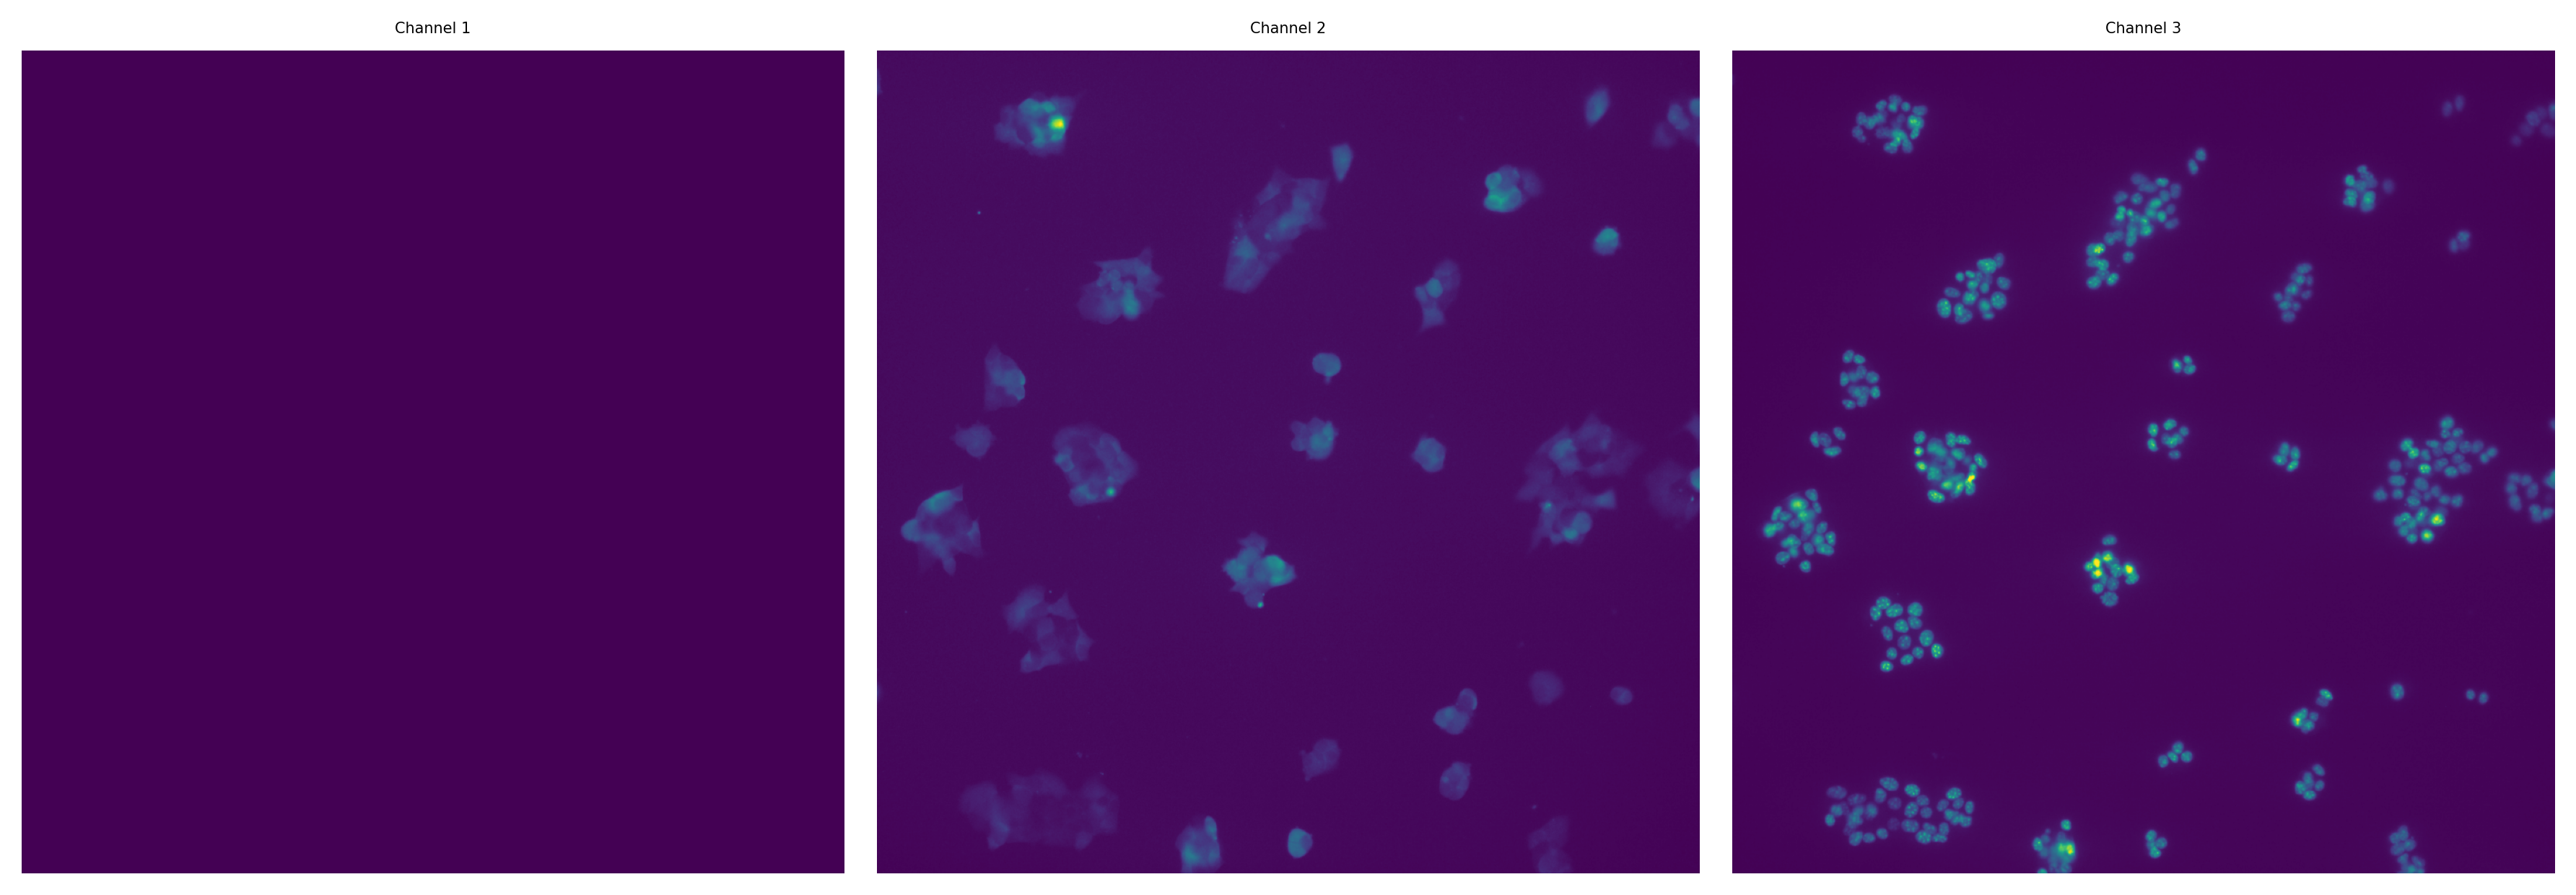

In [10]:
print("Image form: "+image_form.value)
print("Image file type: "+ file_type.value)

imgsep = image_form.value

if file_type.value == "TIFF":
    img_format = ".tif"
elif file_type.value =="JPG":
    img_format = ".jpg"
else:
    img_format = ".png"

fname1 = os.listdir(input_dir)
fname = [item for item in fname1 if item.endswith(img_format)]    
    
# Image stack requires all frames to be seperated into individual images
if imgsep =="Image Stack":
    imgstack = io.imread(input_dir+fname[0])
    dims = imgstack.shape
    print(dims)
    fname = re.sub(rf"\b{img_format}\b","",fname[0])
    
    # Create or empty merged sequence dir
    imgsave_dir = input_dir+"MergedSeq/"
    if not os.path.exists(imgsave_dir):
        os.mkdir(imgsave_dir)
    else:
        print("Existing Merged Sequence Directory found. Deleting it.")
        shutil.rmtree(imgsave_dir)
        os.mkdir(imgsave_dir)
    
    #Creating Image Sequence of TIFF Stack
    count = 0
    for i in range(dims[0]):
        skimage.io.imsave(imgsave_dir+fname+str(count)+".tif",imgstack[i], check_contrast=False)
        print(count)
        count += 1  
    fname1 = os.listdir(input_dir)
    fname = [item for item in fname1 if item.endswith(img_format)] 
    
else: 
    imgsave_dir = input_dir

# Creating/Emptyingc Mask folder
save_dir = input_dir+"Masks/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
else:
    print("Existing Mask Directory found. Deleting it.")
    shutil.rmtree(save_dir)

    
if(len(fname)==0):
    print("Number of images loaded: %d." %(len(fname)))
    print("Cannot read image files. Check if folder has images")
else:
    print("Number of images loaded: %d." %(len(fname)))
    
# Reading all images and displaying one at random 
imgs = []
for im in range(len(fname)):
    im = skimage.io.imread(imgsave_dir + fname[im])
    n_dim=len(im.shape) #shape of image
    dim=im.shape #dimensions of image
    channel=min(dim) #channel will be dimension with min value usually
    channel_position=dim.index(channel)
    #if no of dim is 3 and channel is first index, swap channel to last index
    if n_dim==3 and channel_position==0: 
        #print(dim)
        im=im.transpose(1,2,0)
        dim=im.shape
        #print("Shape changed")
        #print(dim)
    imgs.append(im)
print("Number of images read: " + str(len(imgs)))
print("Example Image:")
random_idx = random.choice(range(len(imgs)))
x=imgs[random_idx]
n_dim=len(x.shape)
file_name=os.path.basename(fname[random_idx])
print(file_name+" has "+str(n_dim)+" dimensions/s")
if n_dim==3:
    channel_image=x.shape[2]
    fig, axs = plt.subplots(1, channel_image,figsize=(12,5))
    print("Image: %s" %(file_name))
    for channel in range(channel_image):
        axs[channel].imshow(x[:,:,channel])
        axs[channel].set_title('Channel '+str(channel+1),size=5)
        axs[channel].axis('off')
    fig.tight_layout()
elif n_dim==2:
    print("One Channel")
    #plt.imshow(x)
    display(x)
else:
    print("Channel number invalid or dimensions wrong. Image shape is: "+str(x.shape))

<h3> Step 3.3: Set Cellpose parameters and run test segmentation </h3>
<hr>

<ul>
    <li> Choose a model option. </li>
        <ul>
            <li>Cytoplasm and Cytoplasm2 will work for whole cell imaging. Nuclei will work well for images with only DAPI staining. </li>
            <li>Only DAPI segmentation may not perform well for subsequent tracking and analysis steps.</li>
    </ul>
    <li> Choose the channel that contains the entire cell to segment. You can reference the images above to find the correct channel.</li>
        <ul>
            <li> Keep the channel at 0 if you only have one channel.</li>
    </ul>
    <li> Choose the channel with your DAPI stain. <b> If you do not have a DAPI stain, keep the channel at 0</b>.
    <li> Cell Probability Threshold </li>
            



</ul>
    
        
        

In [11]:
Model_Choice = widgets.ToggleButtons(
    options=['Cytoplasm', 'Cytoplasm2', 'Nuclei'],
    value = 'Cytoplasm2',
    description='Select One', 
)
display(Model_Choice)

segchan=widgets.Dropdown(
    options=['0','1', '2', '3'],
    value='2',
    description='Cell Channel:',
    disabled=False,
)
display(segchan)

qDapi=widgets.Dropdown(
    options=['1', '2', '3'],
    value='3',
    description='DAPI Channel:',
    disabled=False,
)
display(qDapi)

cellprob=widgets.FloatSlider(
    value=-3,
    min=-6, # max exponent of base
    max=6, # min exponent of base
    step=1.0, # exponent step
    description='Cell Probability'
)
display(cellprob)

flowthresh = widgets.FloatSlider(
    value=0.9,
    min=0.1, # max exponent of base
    max=1.1, # min exponent of base
    step=0.1, # exponent step
    description='Flow Threshold'
)
display(flowthresh)

ToggleButtons(description='Select One', index=1, options=('Cytoplasm', 'Cytoplasm2', 'Nuclei'), value='Cytopla…

Dropdown(description='Cell Channel:', index=2, options=('0', '1', '2', '3'), value='2')

Dropdown(description='DAPI Channel:', index=2, options=('1', '2', '3'), value='3')

FloatSlider(value=-3.0, description='Cell Probability', max=6.0, min=-6.0, step=1.0)

FloatSlider(value=0.9, description='Flow Threshold', max=1.1, min=0.1)

Model choice is: Cytoplasm2
Segmentation channel is: 2
DAPI channel is: 3
Cell probability threshold: -3.0


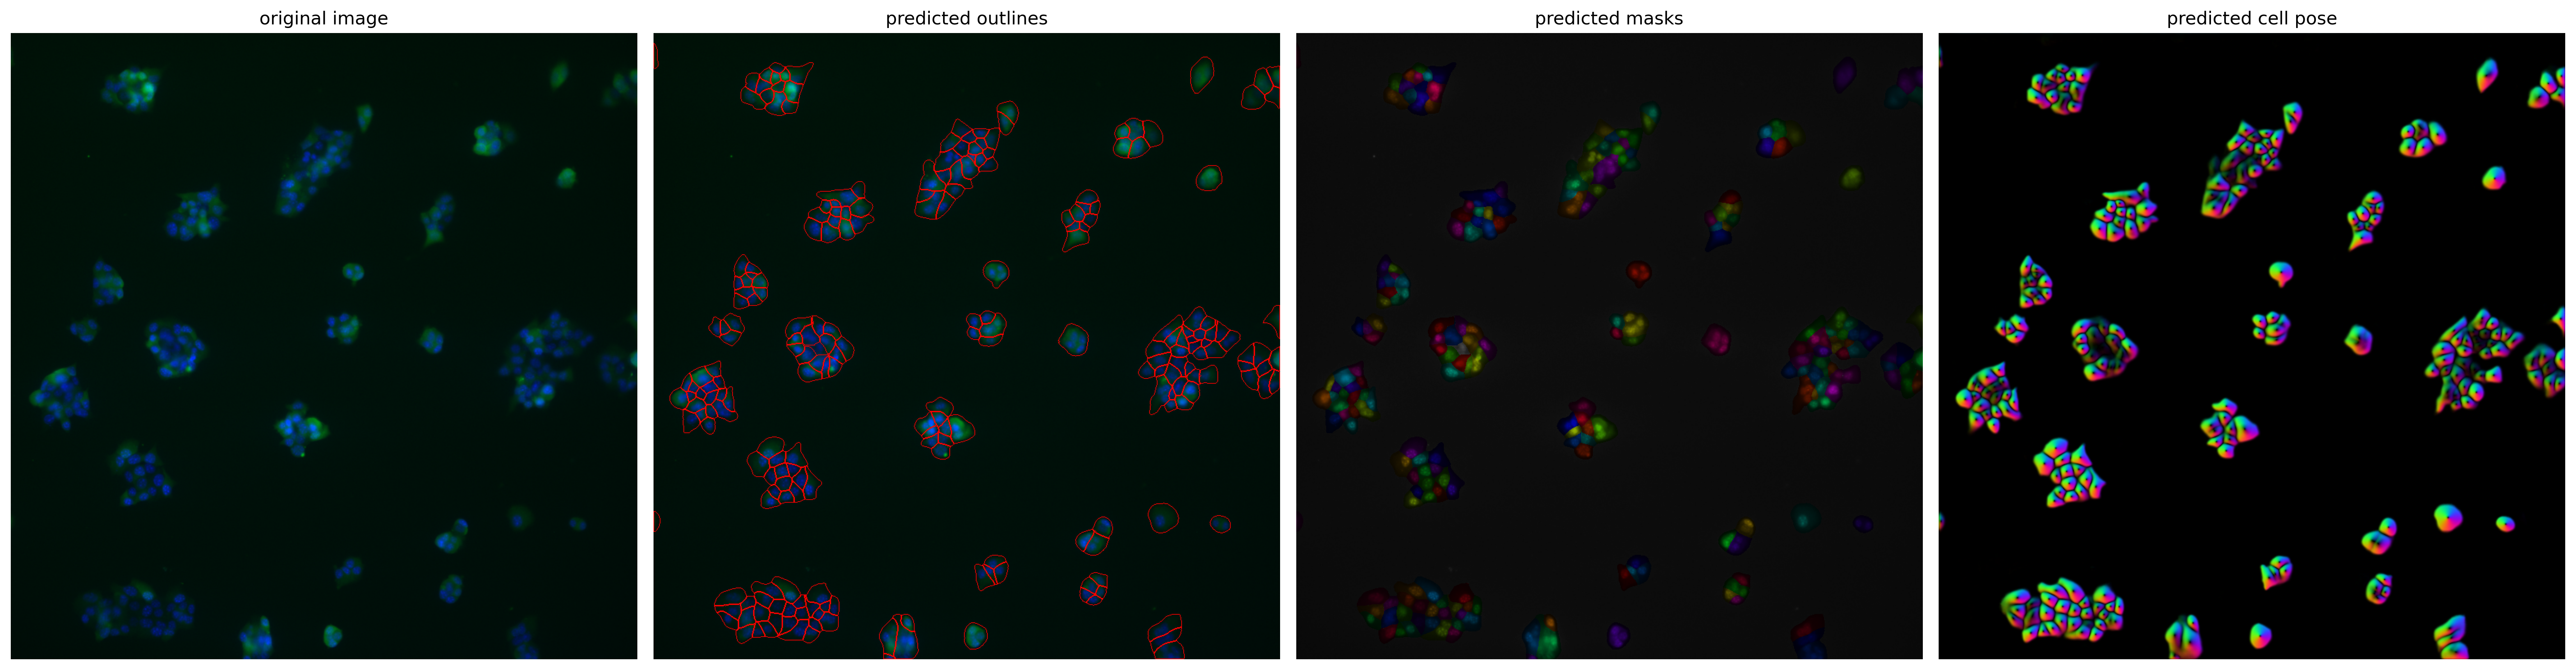

In [12]:
import torch
print("Model choice is: " + Model_Choice.value)
print("Segmentation channel is: " + str(segchan.value))
if qDapi.value == 0:
    Use_nuclear_channel = False
    print("No DAPI Channel")
else:
    Use_nuclear_channel = True
    print("DAPI channel is: " + qDapi.value)

print("Cell probability threshold: " + str(cellprob.value))
      
model_choice = Model_Choice.value
segment_channel = int(segchan.value)
nuclear_channel = int(qDapi.value)

if model_choice=="Cytoplasm":
  model_type="cyto"
elif model_choice=="Cytoplasm2":
  model_type="cyto2"
elif model_choice=="Nuclei":
  model_type="nuclei" 

# channels = [cytoplasm, nucleus]
if model_choice not in "Nucleus":
  if Use_nuclear_channel:
    channels=[segment_channel,nuclear_channel]
  else:
    channels=[segment_channel,0]
else: #nucleus
  channels=[segment_channel,0]

# DEFINE CELLPOSE MODEL
model = models.Cellpose(gpu=use_GPU, model_type=model_type)
print(model)
diameter = None
from skimage.util import img_as_ubyte

flow_threshold=flowthresh.value
cellprob_threshold=cellprob.value

# You can change the test image here
img1=imgs[1]
import cv2
masks, flows, styles, diams = model.eval(img1,diameter=None,flow_threshold=flow_threshold,cellprob_threshold=cellprob_threshold, channels=channels)

# DISPLAY RESULTS
from cellpose import plot
maski = masks
flowi = flows[0]

#convert to 8-bit if not so it can display properly in the graph
if img1.dtype!='uint8':
  img1=img_as_ubyte(img1)

fig = plt.figure(figsize=(24,8))
plot.show_segmentation(fig, img1, maski, flowi, channels=channels)
plt.tight_layout()
plt.show()

In [13]:

#save images in folder with the diameter value used in cellpose
print("Segmentation Done. Saving Masks and flows now")
print("Save Directory is: ",save_dir)
if (not os.path.exists(save_dir)):
    os.mkdir(save_dir)

for img_idx in range(len(fname)):
    file_name=fname[img_idx]
    print("\nSegmenting: ",file_name)
    mask, flow, style, diam = model.eval(imgs[img_idx], diameter=diameter, flow_threshold=flow_threshold,cellprob_threshold=cellprob_threshold, channels=channels)
    # Save name for masks
    mask_output_name=save_dir+"MASK_"+file_name+".tif"
    # Save mask as 16-bit in case this has to be used for detecting than 255 objects
    # A 16-bit image will look black until opened in software such as ImageJ
    # Change "uint16" to "uint8" if you want the preview to be visible 
    mask=mask.astype(np.uint16)
    skimage.io.imsave(mask_output_name, mask, check_contrast=False)
 
print("\nSegmentation complete and files saved")

Segmentation Done. Saving Masks and flows now
Save Directory is:  /home/ama0367/Automation/Scripts/CellPoseImg/Masks/

Segmenting:  DAPIMerge20.tif

Segmenting:  DAPIMerge6.tif

Segmenting:  DAPIMerge16.tif

Segmenting:  DAPIMerge9.tif

Segmenting:  DAPIMerge21.tif

Segmenting:  DAPIMerge13.tif

Segmenting:  DAPIMerge4.tif

Segmenting:  DAPIMerge8.tif

Segmenting:  DAPIMerge14.tif

Segmenting:  DAPIMerge3.tif

Segmenting:  DAPIMerge23.tif

Segmenting:  DAPIMerge5.tif

Segmenting:  DAPIMerge11.tif

Segmenting:  DAPIMerge24.tif

Segmenting:  DAPIMerge17.tif

Segmenting:  DAPIMerge19.tif

Segmenting:  DAPIMerge10.tif

Segmenting:  DAPIMerge2.tif

Segmenting:  DAPIMerge18.tif

Segmenting:  DAPIMerge1.tif

Segmenting:  DAPIMerge0.tif

Segmenting:  DAPIMerge7.tif

Segmenting:  DAPIMerge12.tif

Segmenting:  DAPIMerge15.tif

Segmenting:  DAPIMerge22.tif

Segmentation complete and files saved


<h2> Step 4. Cell registration and tracking </h2>
<hr>

<ul>
    <li> The first terminal command will merge the mask images with their corresponding orginal beta cell image to begin cell registration. </li>
    <li> The second terminal command will push 

In [17]:
!./Fiji.app/ImageJ-linux64 --headless -macro ./MaskMerge.ijm '/home/ama0367/Automation/Scripts/'
!./Fiji.app/ImageJ-linux64 --headless ./LabelLapLinuxTerminalJup.py

OpenJDK 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
OpenJDK 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release
Directory: /home/ama0367/Automation/Scripts/
Merged Mask/Beta Cell Image Saved
OpenJDK 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
OpenJDK 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release
Beginning TrackMate process...

Compisite image is loaded
Detector Settings Configured
Tracker settings configured
Computing spot features over 1 frame simultaneously and allocating 16 threads per frame.

Computation done in 10 ms.

Computing track features:

  - Branching analyzer in 0 ms.

  - Track duration in 0 ms.

  - Track index in 0 ms.

  - Track location in 0 ms.

  - Track speed in 0 ms.

  - Track quality in 0 ms.

  - Track motility analysis in 0 ms.

Computation done in 1 ms.

Initiat

	spot ID = 4879: x=623.437357631, y=235.309794989, t=24.0, q=439.0, snr=0.978963443047, mean = 303.273348519
	spot ID = 593: x=623.394859813, y=235.074766355, t=3.0, q=428.0, snr=0.97551600066, mean = 294.628504673
	spot ID = 914: x=622.142589118, y=236.322701689, t=0.0, q=533.0, snr=0.99221494603, mean = 297.155722326
	spot ID = 1749: x=623.01059322, y=235.675847458, t=14.0, q=472.0, snr=1.04894423798, mean = 301.370762712
	spot ID = 4951: x=623.473568282, y=235.416299559, t=23.0, q=454.0, snr=0.876574200176, mean = 301.764317181
	spot ID = 348: x=623.345733042, y=235.262582057, t=8.0, q=457.0, snr=1.02857538234, mean = 302.122538293
	spot ID = 2211: x=623.015748031, y=235.275590551, t=9.0, q=508.0, snr=0.913444678398, mean = 295.980314961
	spot ID = 4772: x=622.3203125, y=236.119140625, t=19.0, q=512.0, snr=1.01611914114, mean = 303.25390625
	spot ID = 4006: x=622.759381898, y=235.653421634, t=16.0, q=453.0, snr=1.03498921027, mean = 298.333333333
	spot ID = 4903: x=623.528541226, y=

	spot ID = 4424: x=100.963855422, y=423.506024096, t=21.0, q=249.0, snr=0.886563415894, mean = 368.883534137
	spot ID = 2059: x=100.333333333, y=422.975438596, t=2.0, q=285.0, snr=1.06477825432, mean = 355.578947368
	spot ID = 268: x=101.791338583, y=423.228346457, t=1.0, q=254.0, snr=1.81874184775, mean = 458.244094488
	spot ID = 4049: x=101.229437229, y=423.151515152, t=16.0, q=231.0, snr=0.98373937751, mean = 352.103896104
	spot ID = 2515: x=101.242152466, y=423.004484305, t=6.0, q=223.0, snr=1.12716393085, mean = 352.165919283
	spot ID = 787: x=102.540229885, y=424.477011494, t=15.0, q=174.0, snr=0.901407551039, mean = 381.879310345
	spot ID = 791: x=102.027777778, y=423.759259259, t=8.0, q=216.0, snr=1.19733393593, mean = 376.009259259
	spot ID = 667: x=101.928571429, y=423.576190476, t=11.0, q=210.0, snr=0.954944715645, mean = 383.028571429
	spot ID = 1119: x=102.078817734, y=424.266009852, t=3.0, q=203.0, snr=0.973039658103, mean = 368.137931034
	spot ID = 3616: x=101.930735931,

	spot ID = 16: x=141.402384501, y=94.0223546945, t=1.0, q=671.0, snr=1.0991838154, mean = 333.354694486
	spot ID = 1681: x=141.418181818, y=94.3496503497, t=6.0, q=715.0, snr=0.9960128505, mean = 341.496503497
	spot ID = 466: x=141.774052478, y=94.2288629738, t=10.0, q=686.0, snr=1.03781316619, mean = 338.463556851
	spot ID = 792: x=141.92, y=94.6757142857, t=13.0, q=700.0, snr=0.999612084427, mean = 335.884285714
	spot ID = 4377: x=142.004310345, y=94.3951149425, t=17.0, q=696.0, snr=1.0537126758, mean = 331.926724138
	spot ID = 4572: x=142.047142857, y=94.4371428571, t=24.0, q=700.0, snr=1.10109213498, mean = 344.148571429
	spot ID = 4254: x=142.107449857, y=94.0859598854, t=20.0, q=698.0, snr=1.08889214416, mean = 349.899713467
	spot ID = 2146: x=141.715517241, y=94.5775862069, t=4.0, q=696.0, snr=1.02498027373, mean = 331.521551724
	spot ID = 364: x=141.547337278, y=94.7603550296, t=3.0, q=676.0, snr=1.09525315993, mean = 336.329881657
	spot ID = 45: x=141.590116279, y=94.372093023

Track 79: mean velocity = 1.0474773959 pixels/frames
	spot ID = 5696: x=797.8203125, y=491.540625, t=23.0, q=640.0, snr=1.03042358035, mean = 330.3015625
	spot ID = 2818: x=797.69023569, y=491.343434343, t=5.0, q=594.0, snr=1.06881554662, mean = 291.107744108
	spot ID = 1730: x=797.982026144, y=491.281045752, t=15.0, q=612.0, snr=1.08512881345, mean = 349.220588235
	spot ID = 4098: x=797.275290216, y=491.265339967, t=16.0, q=603.0, snr=0.964173149832, mean = 290.07628524
	spot ID = 4997: x=798.04745167, y=491.729349736, t=20.0, q=569.0, snr=0.926738090452, mean = 277.168717047
	spot ID = 2567: x=797.936877076, y=491.22923588, t=2.0, q=602.0, snr=0.979381206889, mean = 264.546511628
	spot ID = 2955: x=796.654891304, y=491.904891304, t=9.0, q=736.0, snr=0.856452633648, mean = 348.220108696
	spot ID = 1169: x=798.081081081, y=490.926868045, t=8.0, q=629.0, snr=1.00717512437, mean = 319.197138315
	spot ID = 1105: x=797.499178982, y=491.622331691, t=10.0, q=609.0, snr=1.12259233635, mean = 

	spot ID = 1339: x=187.67287234, y=646.864361702, t=7.0, q=376.0, snr=0.427382786423, mean = 289.204787234
	spot ID = 3259: x=187.752066116, y=646.672176309, t=14.0, q=363.0, snr=0.191966084382, mean = 290.049586777
	spot ID = 3837: x=187.04534005, y=646.788413098, t=6.0, q=397.0, snr=0.395416787936, mean = 288.647355164
	spot ID = 1343: x=187.392105263, y=647.068421053, t=8.0, q=380.0, snr=0.48170611862, mean = 295.268421053

Track 142: mean velocity = 0.985805269624 pixels/frames
	spot ID = 1344: x=205.574229692, y=660.246498599, t=7.0, q=357.0, snr=-0.0403776405048, mean = 249.165266106
	spot ID = 1347: x=204.850415512, y=660.013850416, t=8.0, q=361.0, snr=0.146912858064, mean = 251.908587258
	spot ID = 2563: x=205.022727273, y=660.235795455, t=15.0, q=352.0, snr=0.008816866476, mean = 249.869318182
	spot ID = 3268: x=205.016666667, y=659.891666667, t=14.0, q=360.0, snr=-0.163671926766, mean = 247.283333333
	spot ID = 3845: x=205.881481481, y=661.049382716, t=4.0, q=405.0, snr=0.274

	spot ID = 258: x=461.477351916, y=166.163763066, t=7.0, q=287.0, snr=1.85402299576, mean = 523.355400697
	spot ID = 1666: x=460.950980392, y=166.153594771, t=12.0, q=306.0, snr=1.84855755877, mean = 559.594771242
	spot ID = 4291: x=460.830564784, y=166.043189369, t=20.0, q=301.0, snr=1.40437482454, mean = 473.033222591
	spot ID = 1989: x=461.052631579, y=165.654605263, t=9.0, q=304.0, snr=1.69775161236, mean = 490.230263158
	spot ID = 4741: x=461.23630137, y=165.787671233, t=24.0, q=292.0, snr=1.5489613924, mean = 480.664383562
	spot ID = 3989: x=461.055016181, y=166.213592233, t=16.0, q=309.0, snr=1.75326919107, mean = 487.71197411
	spot ID = 4245: x=460.752650177, y=166.22614841, t=21.0, q=283.0, snr=1.79713645668, mean = 503.455830389
	spot ID = 470: x=460.665505226, y=166.243902439, t=3.0, q=287.0, snr=1.81064271887, mean = 500.783972125
	spot ID = 214: x=461.434163701, y=165.939501779, t=15.0, q=281.0, snr=1.86219180351, mean = 517.338078292
	spot ID = 4762: x=461.086642599, y=16

<h2> Step 5. Background Subtraction </h2>
<hr>

<ul>
    <li> Random pixel locations will be chosen and compared to every mask frame to ensure the location is not within a cell. </li>
    <li> If the location is not within a cell, the pixel value from every frame will be saved in a csv named "backgroundsub". </li>
    <li> This will be used in the next step for background subtraction for signal analysis. </li>
    <li> <b> Images can only be one channel for this script to work correctly. </b>
</ul>

In [15]:
import os
from skimage import io
from matplotlib import pyplot as plt
import numpy as np
import csv
import random
from statistics import mean

#get path for image loading
dir_path = os.getcwd()

#load stacked original images and mask images
imspike = io.imread(dir_path+'/Scaled_Beta_Cells.tif')
immask = io.imread(dir_path+'/MaskStack.tif')

# Get dimensions for each image (frames, 900, 900, # of channels)
dims=imspike.shape
dimsm=immask.shape
print("Image dimensions: " + str(dims))
# How many pixels to sample
spotnum = 100

# Create array for pixel values of all 100 spots
x = []
for index in range(0,dims[0]):
    x.append([None]*spotnum)

count = 0
# Array to house locations that are not masks
goodlocs=[]
tmpx = []
while count<spotnum:
    loc = []
    imgval = []
    #random pixel location
    x1tmp = random.randrange(0,int(len(imspike[1])))
    y1tmp = random.randrange(0,int(len(imspike[1])))
    imgloc = [int(x1tmp),int(y1tmp)]
    tmpx = np.array([None]*int(dims[0]))
    for img in range(dims[0]):
        #pixel intensity from all three channels
        imgval = imspike[img,imgloc[0],imgloc[1]] #8bit
        maimgval = immask[img,imgloc[0],imgloc[1]]
        # If intensity on mask image is 0, the pixel location is *not* within a cell 
        if np.all(maimgval==0):
            tmpx[img]=imgval 
        # If intensity on mask image is *not* 0, all temporary variables are emptied   
        else:
            maimagval = []
            imgval = []
            imgloc=[]
            break
    if None in tmpx:
      # Empty out temporary array if there are any "None"s left
      tmpx = []
    else: 
      # Save temporary array into large array will all intensity values  
        for do in range(dims[0]):
            x[do][count] = tmpx[do]
        # Save pixel location  
        goodlocs.append(imgloc)
        count += 1

# Header row names for csv
heads = []
for namez in range(spotnum):
    heads.append('Spot '+ str(namez))

# Saving pixel locations for reference
spotz = []
for locz in range(spotnum):
    spotz.append('('+str(goodlocs[locz][1])+'/'+str(goodlocs[locz][0])+')')

print("Locations of background subtraction: " + str(spotz))


# Save intensity values of all 100 pixel locations across all frames
filename = dir_path+"/backgroundsub.csv"
with open(filename,'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter = ',',lineterminator='\r')
    csvwrite2 = csv.writer(csvfile, delimiter = ' ',lineterminator='\r')
    csvwriter.writerow(heads)
    csvwriter.writerow(spotz)
    for i in range(len(x)):
        csvwriter.writerow(x[i])

Image dimensions: (25, 900, 900)
Locations of background subtraction: ['(417/801)', '(150/875)', '(144/478)', '(445/880)', '(323/312)', '(460/237)', '(635/670)', '(627/210)', '(824/863)', '(381/592)', '(865/33)', '(18/652)', '(487/280)', '(742/406)', '(806/78)', '(380/222)', '(177/141)', '(644/748)', '(366/9)', '(767/825)', '(251/396)', '(351/272)', '(472/894)', '(439/440)', '(348/248)', '(399/24)', '(588/326)', '(547/94)', '(211/897)', '(600/699)', '(271/745)', '(761/786)', '(324/292)', '(19/642)', '(543/527)', '(25/25)', '(394/851)', '(456/535)', '(25/428)', '(330/281)', '(42/481)', '(603/843)', '(535/298)', '(846/522)', '(841/522)', '(707/584)', '(463/633)', '(478/611)', '(375/821)', '(560/447)', '(431/319)', '(806/267)', '(467/661)', '(348/206)', '(593/569)', '(83/152)', '(390/498)', '(139/689)', '(321/758)', '(634/186)', '(65/697)', '(575/755)', '(684/775)', '(189/12)', '(151/657)', '(568/144)', '(124/138)', '(833/266)', '(283/718)', '(151/584)', '(239/378)', '(482/464)', '(395/73

<h2> Step 6. Statistical Analysis </h2>
<hr>

<ul>
    <li> This will run the statistical R script. This should output three figures and a CSV file names Experimental_Data.csv you can use in custom analyses. This file has all tracks that do not span the full image stack and identifies tracks in the top 20% of signal variance. </li>
</ul>


In [16]:
!Rscript Beta_Buddy_Stats.R

Loading required package: ggplot2
[1] "ggplot2 is loaded correctly"
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

[1] "dplyr is loaded correctly"
Loading required package: cowplot
[1] "cowplot is loaded correctly"
Loading required package: tidyr
[1] "tidyr is loaded correctly"
Joining, by = "FRAME"
[1] 334
[1] 205
Joining, by = "TRACK_ID"
[1] "Stats Run Complete!"
